# Cuaderno 02: Análisis Morfológico Integral de Astrocitos

**Objetivo:** Este cuaderno carga las máscaras de astrocitos previamente segmentadas y realiza un análisis cuantitativo completo para caracterizar su morfología y complejidad estructural. El flujo de trabajo está diseñado para ser reproducible y para extraer las métricas clave definidas en el protocolo de análisis.

**Flujo de Trabajo:**
1.  **Configuración**: Definir rutas, parámetros de calibración y análisis.
2.  **Carga de Datos**: Cargar la máscara de astrocitos y el canal GFAP original.
3.  **Análisis Morfológico por Astrocito**: Iterar sobre cada astrocito para calcular:
    * Propiedades del protocolo: Volumen GFAP e intensidad media.
    * Propiedades morfológicas: Volumen del núcleo y territorio celular (envolvente convexa).
    * Análisis de complejidad: Esqueletonización 3D, longitud y número de ramas.
    * Análisis de Sholl para medir la complejidad radial.
4.  **Consolidación y Guardado**: Agrupar todos los resultados en tablas y exportarlos.
5.  **Visualización**: Mostrar los resultados de forma interactiva en Napari y con gráficos.


## Paso 0: Activar el Backend Gráfico y Dependencias

**Importante:** Ejecuta esta celda una sola vez por sesión. El comando mágico `%gui qt` prepara el entorno para mostrar ventanas interactivas como las de Napari. También nos aseguramos de que la librería `skan`, necesaria para el análisis de esqueletos, esté instalada.


In [2]:
%gui qt
%pip install skan --quiet

Note: you may need to restart the kernel to use updated packages.


## Paso 1: Configuración de Rutas y Parámetros

Esta celda centraliza todas las variables que controlan el flujo de trabajo. Definir los parámetros aquí permite ajustar fácilmente el análisis para diferentes imágenes sin modificar el código en las celdas posteriores.

* **Rutas de Archivos**: Se definen las rutas de la imagen original y de la máscara de astrocitos generada en el Cuaderno 01. También se especifican las carpetas de salida para los resultados.
* **Calibración Física**: Los parámetros `PIXEL_WIDTH_UM`, `PIXEL_HEIGHT_UM` y `Z_SPACING_UM` son cruciales. Convierten las mediciones de vóxeles a unidades físicas (micrómetros, µm), asegurando que los resultados sean científicamente válidos y comparables entre experimentos.
* **Parámetros de Análisis**: Se definen los radios y el tamaño del paso para el análisis de Sholl.


In [3]:
from pathlib import Path

# --- Rutas de Archivos de Entrada ---
project_root = Path.cwd().parent
base_filename = "Inmuno 26-07-23.lif - CTL 1-2 a"
subfolder = "CTL/CTL 1-2"
original_image_path = project_root / f"data/raw/{subfolder}/{base_filename}.tif"
final_mask_path = project_root / f"data/processed/{base_filename}/04_final_astrocytes_mask.tif"

# --- Rutas de Archivos de Salida ---
results_dir = project_root / "results/tables"
results_dir.mkdir(parents=True, exist_ok=True)
morphology_output_path = results_dir / f"{base_filename}_full_morphology.csv"
sholl_output_path = results_dir / f"{base_filename}_sholl_analysis.csv"
skeleton_output_dir = project_root / "data/processed" / base_filename / "skeletons"
skeleton_output_dir.mkdir(parents=True, exist_ok=True)

# --- Parámetros de Calibración Física (µm)---
PIXEL_WIDTH_UM = 0.3788
PIXEL_HEIGHT_UM = 0.3788
Z_SPACING_UM = 1.0071
VOXEL_VOLUME_UM3 = PIXEL_WIDTH_UM * PIXEL_HEIGHT_UM * Z_SPACING_UM
PHYSICAL_SCALE = (Z_SPACING_UM, PIXEL_HEIGHT_UM, PIXEL_WIDTH_UM)

# --- Parámetros para el Análisis de Sholl ---
SHOLL_START_RADIUS_UM = 5.0
SHOLL_END_RADIUS_UM = 50.0
SHOLL_STEP_UM = 2.0

## Paso 2: Importación de Librerías y Carga de Datos

En esta sección, importamos todas las librerías de Python necesarias para el análisis. Luego, cargamos en memoria la máscara de astrocitos final y el canal GFAP de la imagen original. Un `try-except` se asegura de que el script se detenga con un mensaje claro si los archivos de entrada no se encuentran.


In [4]:
import tifffile
import numpy as np
import pandas as pd
from skimage.measure import regionprops, label
from skimage.morphology import skeletonize, remove_small_objects
from skimage.filters import threshold_otsu
from scipy.spatial import ConvexHull
import skan
import napari
import matplotlib.pyplot as plt

try:
    astrocyte_mask = tifffile.imread(final_mask_path)
    original_image = tifffile.imread(original_image_path)
    gfap_channel = original_image[:, 1, :, :]
    astrocyte_ids = np.unique(astrocyte_mask)[1:]
    print(f"Datos cargados. Se analizarán {len(astrocyte_ids)} astrocitos.")
except FileNotFoundError:
    print("Error: No se encontraron archivos. Asegúrate de haber ejecutado el cuaderno 01 primero.")

Datos cargados. Se analizarán 88 astrocitos.


## Paso 3: Metodología del Análisis Morfológico

El siguiente bloque de código es el núcleo del análisis. Itera sobre cada astrocito identificado en la máscara y realiza una serie de mediciones:

1.  **Aislamiento y Binarización**: Para cada `astro_id`, se aísla su máscara individual. Paralelamente, el canal GFAP completo se binariza usando el umbral de Otsu para separar la señal del fondo de manera objetiva. La intersección de la máscara individual con la señal GFAP binarizada nos da los procesos específicos de ese astrocito (`astrocyte_processes`).

2.  **Análisis de Procesos (Esqueletonización)**:
    * Se aplica la función `skeletonize` a los procesos del astrocito para obtener una representación de 1 píxel de grosor, similar a un "diagrama de cableado".
    * **Paso Crítico de Limpieza**: Se utiliza `remove_small_objects` para eliminar píxeles aislados del esqueleto. Esto es fundamental para prevenir errores en la librería `skan`, que requiere ramas de al menos 2 píxeles conectados.
    * `skan.summarize` analiza el esqueleto limpio para calcular la **longitud total de los procesos** y el **número de ramas**, métricas clave de la complejidad celular.

3.  **Mediciones del Protocolo**:
    * **Volumen GFAP**: Se calcula sumando todos los vóxeles dentro de `astrocyte_processes` y convirtiendo a µm³. Esto corresponde a la métrica "Área GFAP" del protocolo manual.
    * **Intensidad Media GFAP**: Se calcula la intensidad promedio del canal GFAP original únicamente dentro de los vóxeles de `astrocyte_processes`, cumpliendo con otro requisito del protocolo.

4.  **Análisis de Sholl y Territorio**:
    * El **análisis de Sholl** mide la complejidad radial contando cuántas veces los procesos del astrocito cruzan esferas concéntricas de radios crecientes, centradas en el núcleo.
    * El **Volumen del Territorio** se calcula mediante una "envolvente convexa" (Convex Hull), que es la forma 3D más pequeña que encierra todos los procesos del astrocito, representando su dominio espacial total.


## Paso 4: Ejecución del Análisis Morfológico

In [8]:
# Paso 4: Ejecución del Análisis Morfológico

all_morphology_results = []
all_skeletons = np.zeros_like(astrocyte_mask, dtype=np.uint8)
all_sholl_results = []

# Binarizamos el canal GFAP una sola vez para todos los análisis
gfap_threshold = threshold_otsu(gfap_channel)
binarized_gfap = gfap_channel > gfap_threshold

print("Iniciando análisis morfológico para cada astrocito...")
for i, astro_id in enumerate(astrocyte_ids):
    # --- 1. Aislar el astrocito y calcular propiedades básicas ---
    single_astrocyte_mask_bool = (astrocyte_mask == astro_id)
    props = regionprops(single_astrocyte_mask_bool.astype(np.uint8))[0]
    
    nucleus_volume_voxels = props.area
    centroid_z, centroid_y, centroid_x = props.centroid
    
    # --- 2. Skeletonización y Análisis de Ramas ---
    astrocyte_processes = binarized_gfap & single_astrocyte_mask_bool
    total_length_um = 0
    num_branches = 0
    
    if np.any(astrocyte_processes):
        skeleton_with_dust = skeletonize(astrocyte_processes)
        skeleton = remove_small_objects(skeleton_with_dust, min_size=2, connectivity=1)

        if np.any(skeleton):
            skeleton_uint8 = skeleton.astype(np.uint8)
            all_skeletons += skeleton_uint8 * (i + 1)
            
            # Para silenciar la advertencia y asegurar compatibilidad, se añade separator='-'
            branch_data = skan.summarize(skan.Skeleton(skeleton_uint8, spacing=PHYSICAL_SCALE), separator='-')
            
            # CORRECCIÓN: Volvemos a 'branch-distance' para tu versión de skan
            total_length_um = branch_data['branch-distance'].sum()
            num_branches = len(branch_data)

    # --- 3. Mediciones del Protocolo (Volumen e Intensidad GFAP) ---
    gfap_volume_voxels = np.sum(astrocyte_processes)
    mean_gfap_intensity = 0
    if gfap_volume_voxels > 0:
        mean_gfap_intensity = np.mean(gfap_channel[astrocyte_processes])

    # --- 4. Análisis de Sholl ---
    radii_um = np.arange(SHOLL_START_RADIUS_UM, SHOLL_END_RADIUS_UM, SHOLL_STEP_UM)
    z, y, x = np.indices(astrocyte_mask.shape)
    distances_um = np.sqrt(
        ((z - centroid_z) * Z_SPACING_UM)**2 +
        ((y - centroid_y) * PIXEL_HEIGHT_UM)**2 +
        ((x - centroid_x) * PIXEL_WIDTH_UM)**2
    )
    for j, r_um in enumerate(radii_um):
        r_inner_um = radii_um[j-1] if j > 0 else 0
        shell_mask = (distances_um > r_inner_um) & (distances_um <= r_um)
        intersection_mask = astrocyte_processes & shell_mask
        _, num_intersections = label(intersection_mask, return_num=True)
        all_sholl_results.append({'label': astro_id, 'radius_um': r_um, 'intersections': num_intersections})

    # --- 5. Cálculo del Territorio (Convex Hull) ---
    points = np.argwhere(single_astrocyte_mask_bool)
    territory_volume_um3 = 0
    if len(points) > 3:
        points_um = points * np.array(PHYSICAL_SCALE)
        hull = ConvexHull(points_um)
        territory_volume_um3 = hull.volume
        
    # --- 6. Consolidar resultados para este astrocito ---
    sholl_max = 0
    sholl_results_for_astro = [res['intersections'] for res in all_sholl_results if res['label'] == astro_id]
    if sholl_results_for_astro:
        sholl_max = max(sholl_results_for_astro)

    all_morphology_results.append({
        'label': astro_id,
        'nucleus_volume_um3': nucleus_volume_voxels * VOXEL_VOLUME_UM3,
        'gfap_volume_um3': gfap_volume_voxels * VOXEL_VOLUME_UM3,
        'mean_gfap_intensity': mean_gfap_intensity,
        'total_process_length_um': total_length_um,
        'num_branches': num_branches,
        'territory_volume_um3': territory_volume_um3,
        'sholl_max_intersections': sholl_max
    })
    print(f"Analizado astrocito {astro_id} ({i+1}/{len(astrocyte_ids)})")

print("\nAnálisis morfológico completado.")

Iniciando análisis morfológico para cada astrocito...
Analizado astrocito 26 (1/88)
Analizado astrocito 27 (2/88)
Analizado astrocito 44 (3/88)
Analizado astrocito 111 (4/88)
Analizado astrocito 124 (5/88)
Analizado astrocito 133 (6/88)
Analizado astrocito 136 (7/88)
Analizado astrocito 137 (8/88)
Analizado astrocito 138 (9/88)
Analizado astrocito 140 (10/88)
Analizado astrocito 141 (11/88)
Analizado astrocito 142 (12/88)
Analizado astrocito 145 (13/88)
Analizado astrocito 146 (14/88)
Analizado astrocito 149 (15/88)
Analizado astrocito 150 (16/88)
Analizado astrocito 152 (17/88)
Analizado astrocito 156 (18/88)
Analizado astrocito 158 (19/88)
Analizado astrocito 159 (20/88)
Analizado astrocito 161 (21/88)
Analizado astrocito 163 (22/88)
Analizado astrocito 166 (23/88)
Analizado astrocito 167 (24/88)
Analizado astrocito 168 (25/88)
Analizado astrocito 171 (26/88)
Analizado astrocito 173 (27/88)
Analizado astrocito 176 (28/88)
Analizado astrocito 177 (29/88)
Analizado astrocito 178 (30/88

## Paso 5: Consolidación de Resultados

Los resultados, que se han ido acumulando en listas, se convierten ahora en DataFrames de `pandas` para facilitar su visualización y guardado. También guardamos la imagen que contiene todos los esqueletos generados.


In [9]:
# Crear DataFrames finales a partir de las listas de resultados
morphology_df = pd.DataFrame(all_morphology_results)
sholl_df = pd.DataFrame(all_sholl_results)

# Guardar la imagen con todos los esqueletos para su posterior visualización
tifffile.imwrite(skeleton_output_dir / f"{base_filename}_skeletons.tif", all_skeletons)

print("Resumen de los resultados morfológicos:")
display(morphology_df.head())

Resumen de los resultados morfológicos:


,label,nucleus_volume_um3,gfap_volume_um3,mean_gfap_intensity,total_process_length_um,num_branches,territory_volume_um3,sholl_max_intersections
0,26,96.820504,0.144508,85.000000,0.000000,0,81.020939,1
1,27,115.317556,0.000000,0.000000,0.000000,0,96.386979,0
2,44,229.912570,21.387216,158.351351,1.136400,2,205.779698,3
3,111,204.045600,9.537542,100.000000,5.020887,4,259.729432,5
4,124,90.462143,0.000000,0.000000,0.000000,0,85.067169,0


## Paso 6: Glosario de Resultados Cuantitativos

A continuación se describe el significado de cada métrica calculada en la tabla `morphology_df`.

* `label`: El identificador numérico único para cada astrocito.
* `nucleus_volume_um3`: **Volumen del Núcleo (µm³)**. El volumen del núcleo DAPI-positivo, segmentado por Cellpose en el cuaderno anterior.
* `gfap_volume_um3`: **Volumen GFAP (µm³)**. El volumen 3D total de la señal GFAP asociada al astrocito. Es el equivalente 3D de la "Área GFAP" del protocolo.
* `mean_gfap_intensity`: **Intensidad Media de GFAP**. La intensidad de fluorescencia promedio dentro del volumen GFAP del astrocito.
* `total_process_length_um`: **Longitud Total de Procesos (µm)**. La suma de las longitudes de todas las ramas del esqueleto, una medida de la extensión total del astrocito.
* `num_branches`: **Número de Ramas**. El número de segmentos que componen el esqueleto, indicando la complejidad de la ramificación.
* `territory_volume_um3`: **Volumen del Territorio (µm³)**. El volumen de la envolvente convexa que encierra a toda la célula, representando su dominio espacial total.
* `sholl_max_intersections`: **Máximo de Intersecciones de Sholl**. El número pico de intersecciones del análisis de Sholl, que indica la zona de mayor complejidad de ramificación.


## Paso 7: Visualización de Resultados

La visualización es un paso fundamental para validar los resultados.

* **Napari (Visualización 3D)**: Lanzamos un visor interactivo para inspeccionar cualitativamente los resultados. Podemos superponer el canal GFAP original, las máscaras de los astrocitos y sus esqueletos 3D calculados, todo calibrado a su escala física real.
* **Matplotlib (Gráfico de Sholl)**: Creamos un gráfico 2D del análisis de Sholl para un astrocito de ejemplo. Esto permite visualizar cuantitativamente cómo cambia la complejidad de sus ramificaciones a medida que nos alejamos del centro de la célula.


In [10]:
# Cargar la imagen de esqueletos recién guardada
skeletons_img = tifffile.imread(skeleton_output_dir / f"{base_filename}_skeletons.tif")

# Iniciar el visor de Napari
viewer = napari.Viewer()

# Añadir capas a Napari: canal original, máscaras y esqueletos
viewer.add_image(gfap_channel, name='GFAP', colormap='green', scale=PHYSICAL_SCALE)
viewer.add_labels(astrocyte_mask, name='Astrocitos', scale=PHYSICAL_SCALE, opacity=0.3)
viewer.add_labels(skeletons_img, name='Esqueletos 3D', scale=PHYSICAL_SCALE)

07-Sep-25 13:52:27 - bfio.backends - WARNING  - Java backend is not available. This could be due to a missing dependency (jpype).
/home/daniel/Proyectos/astrocitos-3d-analysis/venv/lib/python3.12/site-packages/npe2/manifest/_npe1_adapter.py:87: UserWarning: Error importing contributions for first-generation napari plugin 'bfio': cannot import name 'cbuffer_sizes' from 'numcodecs.blosc' (/home/daniel/Proyectos/astrocitos-3d-analysis/venv/lib/python3.12/site-packages/numcodecs/blosc.cpython-312-x86_64-linux-gnu.so)
  self._load_contributions()


<Labels layer 'Esqueletos 3D' at 0x7cacf9f8c290>

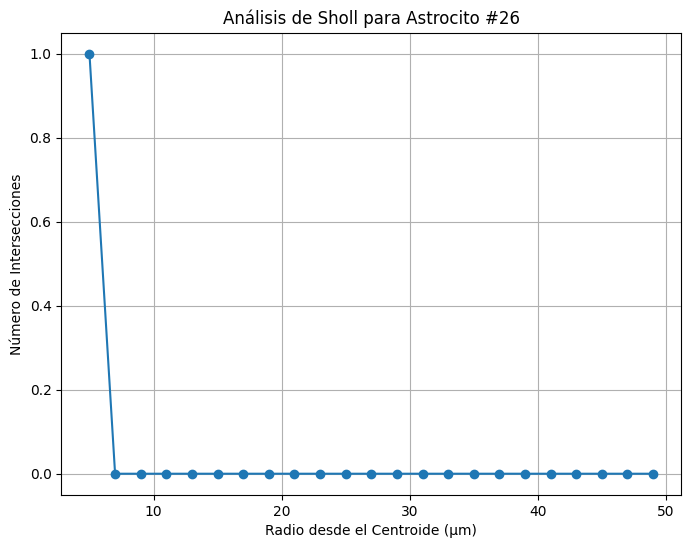

In [11]:
# --- Gráfico de Sholl para un astrocito de ejemplo ---
if not morphology_df.empty and not sholl_df.empty:
    # Seleccionar el primer astrocito de la tabla para graficar
    astrocyte_to_plot = morphology_df['label'].iloc[0]
    sholl_subset = sholl_df[sholl_df['label'] == astrocyte_to_plot]
    
    # Crear el gráfico
    plt.figure(figsize=(8, 6))
    plt.plot(sholl_subset['radius_um'], sholl_subset['intersections'], marker='o', linestyle='-')
    plt.title(f'Análisis de Sholl para Astrocito #{astrocyte_to_plot}')
    plt.xlabel('Radio desde el Centroide (µm)')
    plt.ylabel('Número de Intersecciones')
    plt.grid(True)
    plt.show()

## Paso 8: Guardado Final de Resultados

Finalmente, guardamos las tablas completas con los resultados cuantitativos en archivos de formato CSV. Estos archivos se pueden abrir fácilmente en Excel, R, o cualquier otro software de análisis estadístico para realizar comparaciones entre diferentes condiciones experimentales.


In [12]:
# Guardar la tabla con las métricas morfológicas principales
if 'morphology_df' in locals() and not morphology_df.empty:
    morphology_df.to_csv(morphology_output_path, index=False)
    print(f"Resultados morfológicos guardados en: {morphology_output_path}")

# Guardar la tabla con los datos detallados del análisis de Sholl para todos los astrocitos
if 'sholl_df' in locals() and not sholl_df.empty:
    sholl_df.to_csv(sholl_output_path, index=False)
    print(f"Resultados del análisis de Sholl guardados en: {sholl_output_path}")

Resultados morfológicos guardados en: /home/daniel/Proyectos/astrocitos-3d-analysis/results/tables/Inmuno 26-07-23.lif - CTL 1-2 a_full_morphology.csv
Resultados del análisis de Sholl guardados en: /home/daniel/Proyectos/astrocitos-3d-analysis/results/tables/Inmuno 26-07-23.lif - CTL 1-2 a_sholl_analysis.csv
